In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import (  # HuggingFace Transformer模型工具
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import os

model_path = r"/home/jzyoung/.cache/modelscope/hub/models/deepseek-ai/DeepSeek-R1-Distill-Qwen-1___5B"
data_path = r"./dataset/medical_o1_sft_Chinese.json"
output_path = r"./output/"

# 强制使用GPU（确保CUDA可用）
assert torch.cuda.is_available(), "必须使用GPU进行训练！"
device = torch.device("cuda")  # 指定使用CUDA设备
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []  # 存储损失值的列表

    # 当训练过程中有日志输出时触发
    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:  # 过滤并记录损失值
            self.losses.append(logs["loss"])

def process_data(tokenizer):
    dataset = load_dataset("json", data_files=data_path, split="train[:1500]")

    def format_example(example):
        # 构建指令部分（模型输入）
        instruction = f"诊断问题：{example['Question']}\n### 详细分析及答案："
        # 构建目标部分（模型需要生成的内容）
        target = f"\n详细分析：{example['Complex_CoT']}\n### 答案：{example['Response']}<|endoftext|>"
        # 完整文本拼接
        full_text = instruction + target
        # 分词处理
        inputs = tokenizer(
            full_text,
            padding="max_length",
            truncation=True,
            max_length=1024,
            return_tensors="pt"
        )
        # print(inputs)
        # print(inputs["input_ids"])
        
        # 计算指令部分的token长度（不包含特殊token）
        instruction_encoded = tokenizer(
            instruction,
            add_special_tokens=False  # 禁用特殊token添加
        )["input_ids"]
        instruction_length = len(instruction_encoded)

        # 创建labels（仅目标部分参与loss计算）
        labels = inputs["input_ids"].clone().squeeze(0)
        # 将指令部分设为-100（忽略loss计算）
        labels[:instruction_length] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": labels
        }

    return dataset.map(format_example, remove_columns=dataset.column_names)

2025-03-01 23:07:43.253262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 23:07:43.391157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740841663.439442    1419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740841663.453212    1419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 23:07:43.573252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
peft_config = LoraConfig(
    r=16,               # LoRA秩（矩阵分解维度）
    lora_alpha=32,      # 缩放系数（控制适配器影响强度）
    # target_modules=["q_proj", "v_proj"],  # 要适配的注意力模块（查询/值投影）
    target_modules="all-linear", 
    lora_dropout=0.05,  # 防止过拟合的Dropout率
    bias="none",        # 不训练偏置参数
    task_type="CAUSAL_LM"  # 任务类型（因果语言模型）
)

In [3]:
training_args = TrainingArguments(
    output_dir=output_path,        # 输出目录（模型/日志）
    per_device_train_batch_size=2, # 单GPU批次大小（显存优化）
    gradient_accumulation_steps=4, # 梯度累积步数（等效batch_size=8）
    num_train_epochs=5,            # 训练轮次
    learning_rate=5e-4,            # 初始学习率
    fp16=True,                     # 启用混合精度训练（节省显存）
    logging_steps=20,              # 每隔20步记录日志
    save_strategy="no",            # 不保存中间检查点
    report_to="none",              # 禁用第三方报告（如W&B）
    optim="adamw_torch",           # 优化器类型
    no_cuda=False,                 # 强制使用CUDA
    dataloader_pin_memory=False,   # 禁用锁页内存（加速数据加载）
    remove_unused_columns=False    # 保留未使用的列（避免数据错误）
)

trainable params: 18,464,768 || all params: 1,795,552,768 || trainable%: 1.0284


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

开始训练...


Step,Training Loss
20,1.777800
40,1.413700
60,1.472200
80,1.428000
100,1.380300
120,1.393600
140,1.346300
160,1.337500
180,1.341700
200,1.292000


模型已保存至：./output/
Loss曲线已保存


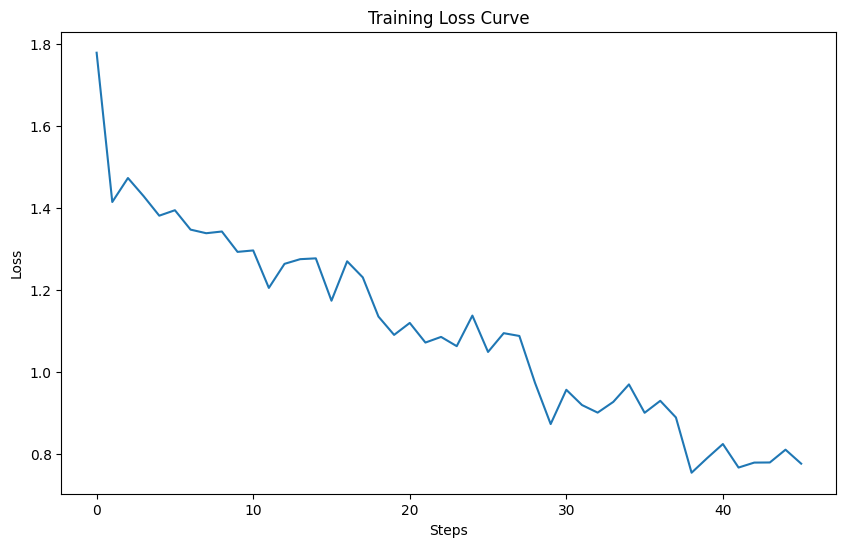

In [4]:
def main():
    # 创建输出目录（如果不存在）
    os.makedirs(output_path, exist_ok=True)

    # 加载Tokenizer并设置填充符
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token  # 使用EOS作为填充符

    # 加载预训练模型（半精度+指定GPU）
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,       # 半精度加载（节省显存）
        device_map={"": device}          # 指定使用的GPU设备
    )
    # 应用LoRA适配器
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()   # 打印可训练参数量

    # 准备训练数据集
    dataset = process_data(tokenizer)

    # 初始化损失记录回调
    loss_callback = LossCallback()

    # 数据整理函数（构造批次）
    def data_collator(data):
        batch = {
            "input_ids": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device),
            "attention_mask": torch.stack([torch.tensor(d["attention_mask"]) for d in data]).to(device),
            "labels": torch.stack([torch.tensor(d["labels"]) for d in data]).to(device)  # 标签=输入（因果LM任务）
        }
        return batch

    # 初始化Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        data_collator=data_collator,  # 自定义数据整理
        callbacks=[loss_callback]     # 添加回调
    )

    # 执行训练
    print("开始训练...")
    trainer.train()

    # 保存微调后的模型
    trainer.model.save_pretrained(output_path)
    print(f"模型已保存至：{output_path}")

    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(loss_callback.losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(output_path, "loss_curve.png"))  # 保存为PNG
    print("Loss曲线已保存")

if __name__ == "__main__":
    main()